**Import the useful package**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from cvxopt import solvers, matrix
from tqdm import tqdm 

Question 1: (10 points) For visualization purpose, generate heat maps of Reward function 1 and
Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots
for this question

Generate the matrix for the reward. (Generate the reward function or reward matrix)

In [2]:
RF_1 = np.array(
    [[0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
     [0,  0,  0,  0,  0,-10,-10,  0,  0,  0],
     [0,-10,-10,  0,  0,  0,  0,  0,  0,  0],
     [0,-10,-10,  0,  0,  0,  0,  0,  0,  0],   
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
     [0,  0,-10,-10,  0,  0,  0,  0,  0,  0],
     [0,  0,-10,-10,  0,  0,  0,  0,  0,  1],
    ]
)
RF_2 = np.array(
    [[0,  0,  0,  0,   0,   0,   0,   0,   0,  0],
     [0,  0,  0,  0,-100,-100,-100,   0,   0,  0],
     [0,  0,  0,  0,-100,   0,-100,   0,   0,  0],
     [0,  0,  0,  0,-100,   0,-100,-100,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,-100,   0,   0,   0,-100,  0],
     [0,  0,  0,  0,   0,   0,-100,-100,-100,  0],
     [0,  0,  0,  0,   0,   0,-100,   0,   0,  0],
     [0,  0,  0,  0,   0,   0,   0,   0,   0,  10],
    ]
)

# translate RF_1 and RF_2 reward function from matrix into vector
RF_1 = RF_1.T.ravel()
RF_2 = RF_2.T.ravel()

Generate the function for plotting the heatmap

In [3]:
def Imshow_HeatMap(data, title = "block"):
  # Create heatmap with numbers
  fig, ax = plt.subplots()
  im = ax.imshow(data, cmap='viridis')
  # Add number annotations to each box
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      text = ax.text(j, i, round(data[i, j], 2),ha="center", va="center", color="w")
  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)
  # Set axis labels and title
  ax.set_title(title)
  # Show plot
  plt.show()



Generate the function for plotting the arrow

In [4]:
def Imshow_Arrow(policy_matrix, title = "block"):
  # define figure and axis by using plt to return
  figure, axis = plt.subplots()
  num = len(policy_matrix)
  # using two point here to represent the index
  min, max = 0, num
 
  for i in range(num):
    for j in range(num):
      pos = policy_matrix[i][j]
      arrow = ''
      if (pos == 0):
        arrow = u'↓'
      elif (pos == 1):
        arrow = u'→'
      elif (pos == 2):
        arrow = u'↑'
      else:
        arrow = u'←'
      axis.text(j+0.5, i+0.5, arrow, va='center', ha='center')
  axis.set_xlim(min, max)
  axis.set_ylim(min, max)
  axis.set_xticks(np.arange(max))
  axis.set_yticks(np.arange(max))
  axis.xaxis.tick_top()
  axis.grid()
  # Set axis labels and title
  axis.set_title(title)
  # Show plot
  plt.show()

Visualize the reward function

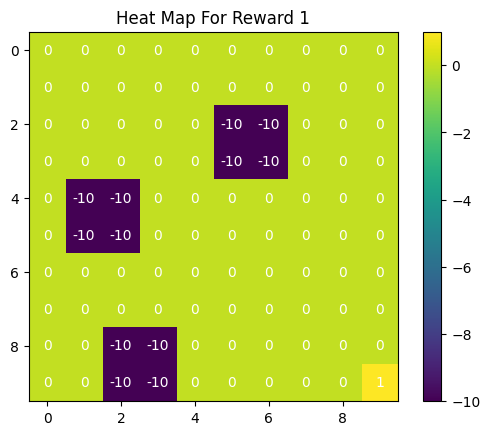

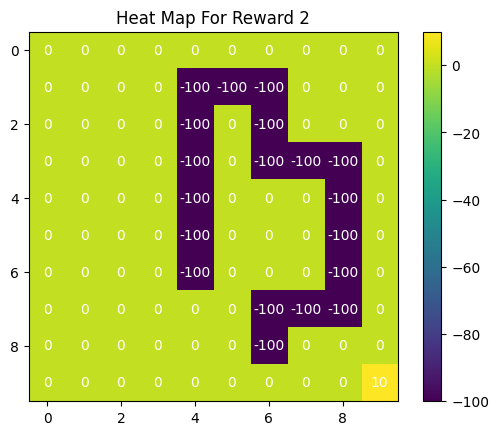

In [5]:
Imshow_HeatMap(RF_1.reshape(10,10).T, 'Heat Map For Reward 1')
Imshow_HeatMap(RF_2.reshape(10,10).T, 'Heat Map For Reward 2')

Question 2: (40 points) Create the environment of the agent using the information provided in section

Generate the 10x10 state

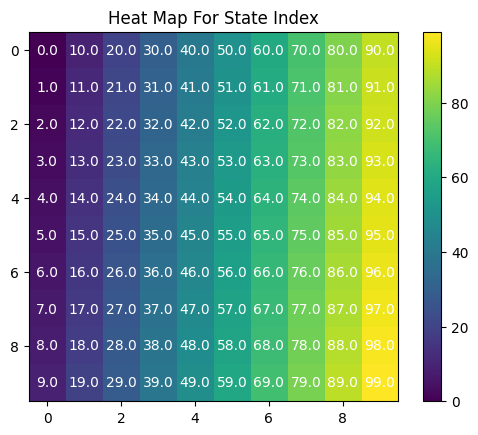

In [6]:
# initialize the state
stateIndex = np.zeros((10, 10))

# initialize the index for each state
countIndex = 0

for ii in range(0,10):
  for jj in range(0,10):
    stateIndex[jj][ii] = countIndex
    countIndex = countIndex + 1

# visualize the state
Imshow_HeatMap(stateIndex, 'Heat Map For State Index')

Generate the whole class for the Markov Decision Process (MDP)

In [7]:
# define the class for the Markov Decision Process

class MDP_gridworld(object):

  def __init__(self, num_of_states, w):
    
    # define the states
    self.num_of_states = num_of_states
    self.max_grid = int(np.sqrt(num_of_states))

    # define the w
    self.w = w

    # define the actions
    # (1,0) represent y axis +1, which is equal to move down
    # (0,1) represent x axis +1, which is equal to move right
    # (-1,0) represent y axis -1, which is equal to move up
    # (0,-1) represent x axis -1, which is equal to move left  
    self.actions = ((1,0),(0,1),(-1,0),(0,-1))
    self.num_of_actions = len(self.actions)

    # generate the transition probability matrix
    self.transition_probability = self.transition_probability_matrix()

  def index_to_grid(self, state):
    # calculate from index of a state to grid
    # as the figure 1 (index 10 -> (0,1)) (index 21 -> (1,2))
    # first return the number of row
    # second return the number of column
    return (state % self.max_grid, state // self.max_grid)

  def grid_to_index(self, grid_position):
    # calculate from index of a grid to state
    # this funciton is the inverse operation of index_to_grid
    return (grid_position[0] + grid_position[1]*self.max_grid)
  
  # calculate the next state from current state is apply one kind of movement
  def state_to_next_state(self, state, move):
    colIndex, rowIndex = self.index_to_grid(state)
    colMove, rowMove = self.actions[move]
    maxIndex = self.max_grid - 1

    # if at the edge or corner
    if (colIndex + colMove < 0) or (colIndex + colMove > maxIndex) or (rowIndex + rowMove < 0) or (rowIndex + rowMove > maxIndex):
      return self.grid_to_index([colIndex, rowIndex])
    else:
      return self.grid_to_index([colIndex + colMove, rowIndex + rowMove])

  # generate the transition probability matrix
  def transition_probability_matrix(self):

    w = self.w
    transition_probability = np.zeros([self.num_of_actions, self.num_of_states, self.num_of_states])
    
    for action in range(0,self.num_of_actions):
      for current_state in range(0,self.num_of_states):
        for move in range(0,self.num_of_actions):
          probability = w / 4
          if move == action:
            probability = probability + 1 - w
          next_state = self.state_to_next_state(current_state, move)
          transition_probability[action][current_state][next_state] = transition_probability[action][current_state][next_state] + probability
    return transition_probability
  

Create the environment

In [8]:
## Generate the parameters for the Markov Decision Process 
num_of_states = 100
w = 0.1

# Make the Markov Decision Process  
MDP_wind = MDP_gridworld(num_of_states, w)

Generate the value iteration function

In [9]:
# the value iteration function will return the optimal state, iteration number, and policy
def value_iteration_function(MDP_gridworld, Reward_function, snapshots = 0, discount_factor = 0.8, epsilon = 0.01):
  
  # initialize the needed parameter
  # the transition probability matrix
  tran_pro = MDP_gridworld.transition_probability;
  # the value matrix for all state
  value_matrix = np.zeros(MDP_gridworld.num_of_states)
  # the delta
  delta = np.inf
  # the policy matrix
  policy_matrix = np.zeros(MDP_gridworld.num_of_states)
  # the total iteration number
  iter = 0

  # estimation step
  while delta > epsilon:
    # initialize the delta for each iteration
    delta = 0
    # calculate the total iteration number
    iter = iter + 1
    # estimate the value matrix for each state
    for temp_state in range(0,MDP_gridworld.num_of_states):
      temp_value = value_matrix[temp_state]
      value_matrix[temp_state] = np.amax(np.matmul(tran_pro[:,temp_state,:],(Reward_function + discount_factor*value_matrix)))
      delta = max(delta, abs(temp_value - value_matrix[temp_state]))
    # visualize the snapshots
    if snapshots != 0:
      print("Iteration Number: ", str(iter))
      Imshow_HeatMap(value_matrix.reshape(10,10).T, " Value Matrix For Iteration Number: "+str(iter))
  
  # compute the policy for each state
  for temp_state in range(0,MDP_gridworld.num_of_states):
    policy_matrix[temp_state] = np.argmax(np.matmul(tran_pro[:,temp_state,:],(Reward_function + discount_factor*value_matrix)))

  return value_matrix, policy_matrix, iter

Apply the value iteration function to the problem

Iteration Number:  1


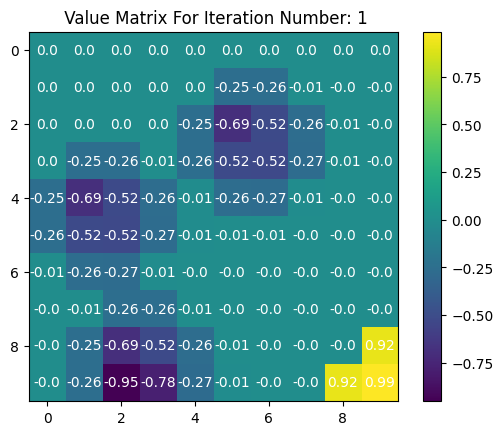

Iteration Number:  2


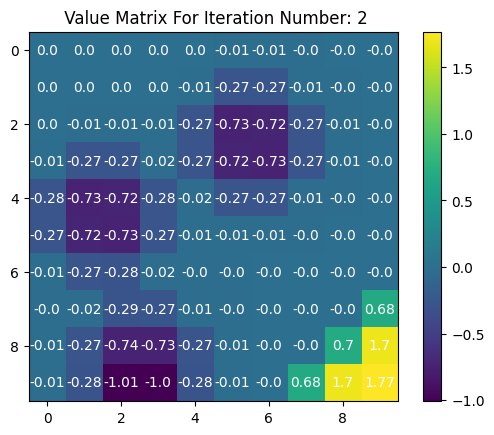

Iteration Number:  3


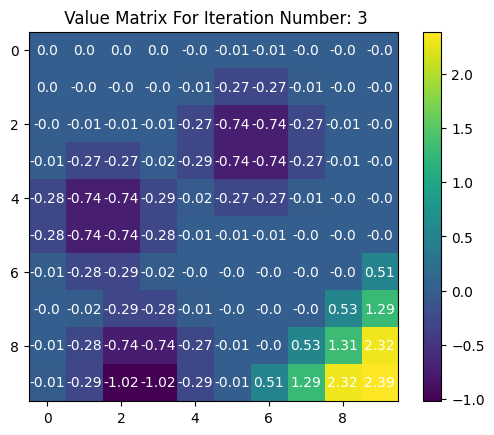

Iteration Number:  4


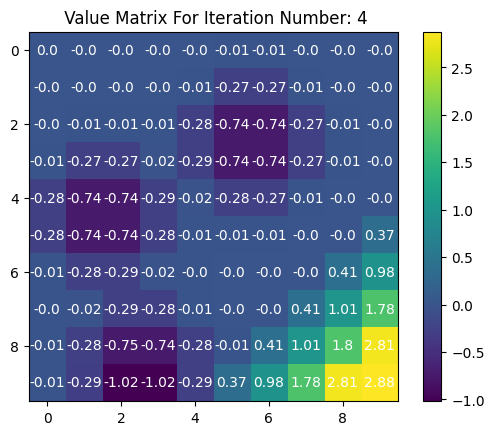

Iteration Number:  5


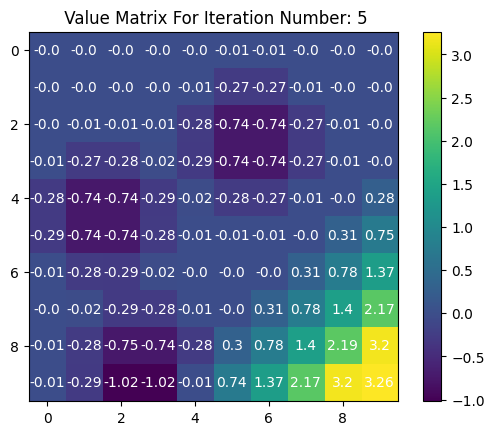

Iteration Number:  6


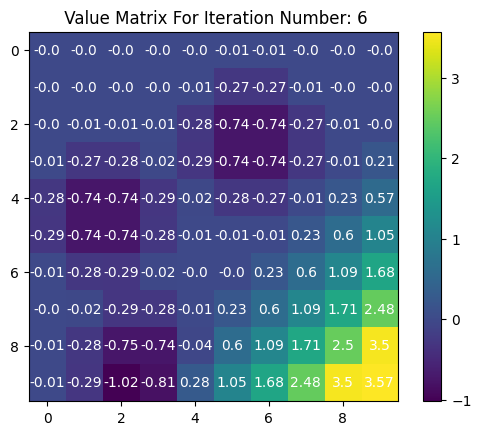

Iteration Number:  7


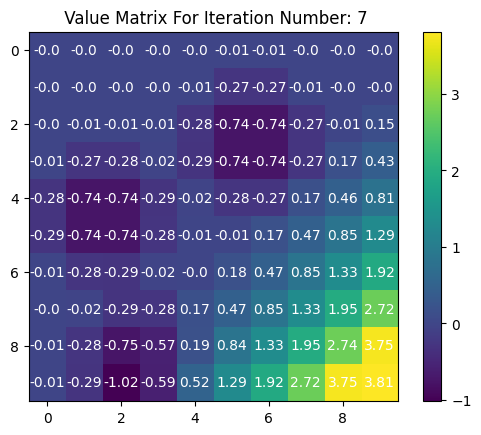

Iteration Number:  8


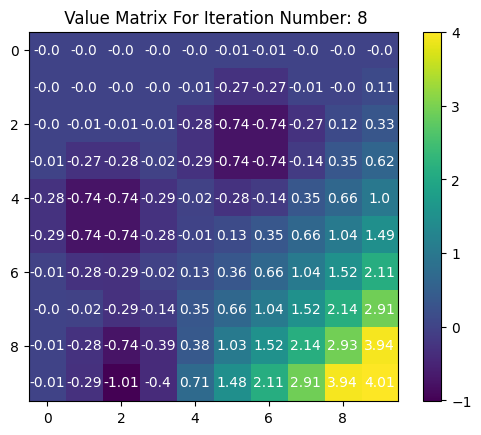

Iteration Number:  9


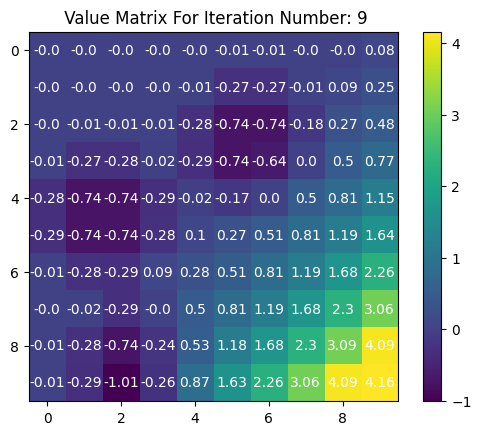

Iteration Number:  10


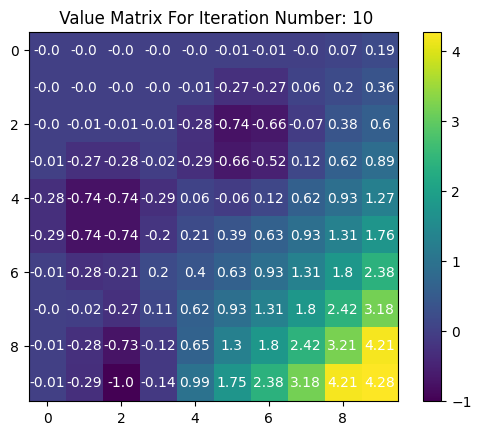

Iteration Number:  11


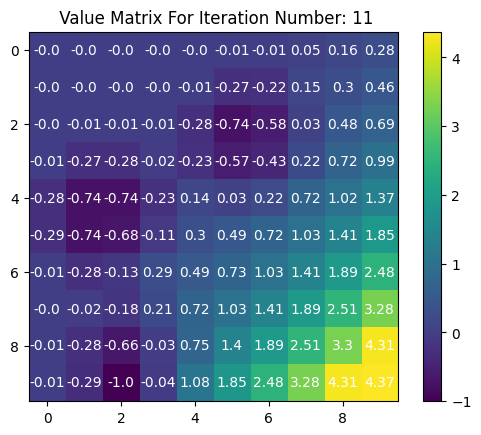

Iteration Number:  12


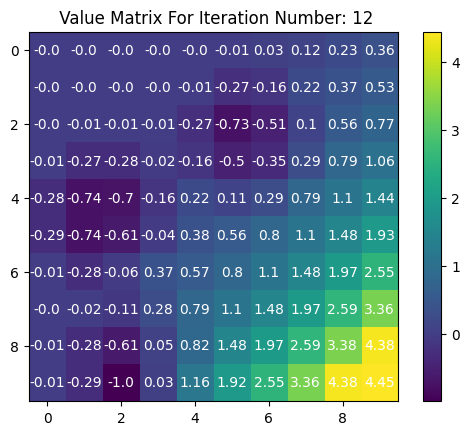

Iteration Number:  13


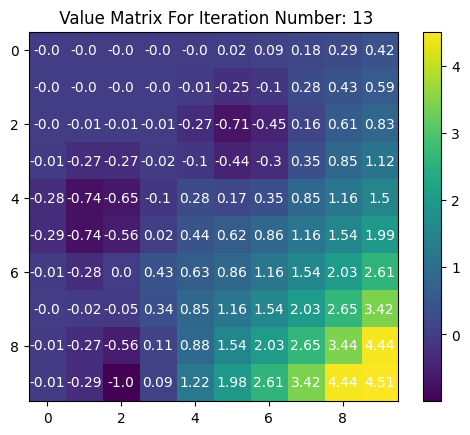

Iteration Number:  14


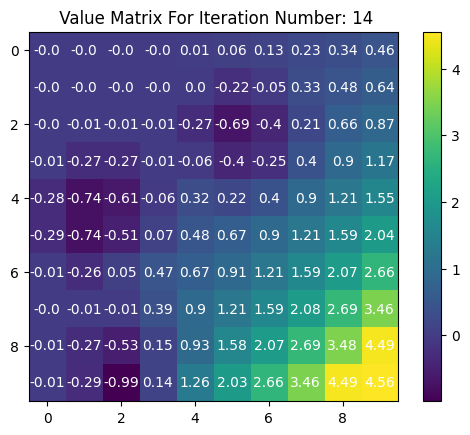

Iteration Number:  15


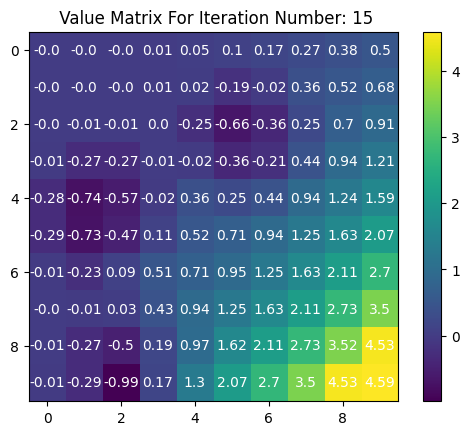

Iteration Number:  16


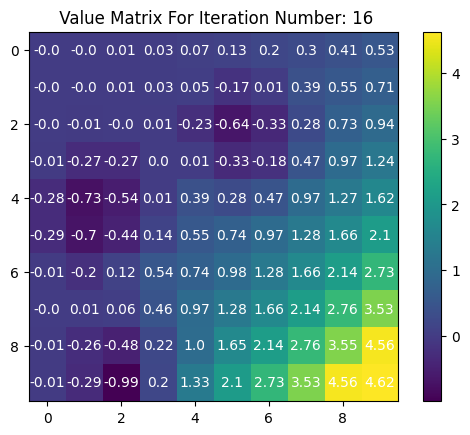

Iteration Number:  17


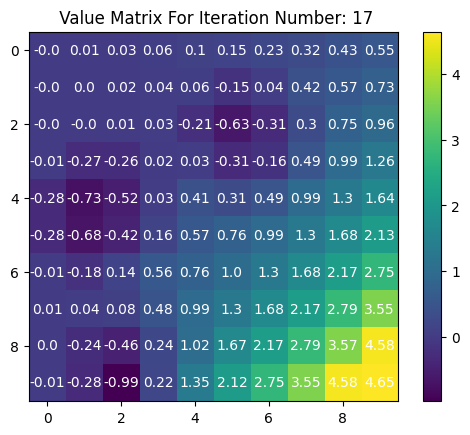

Iteration Number:  18


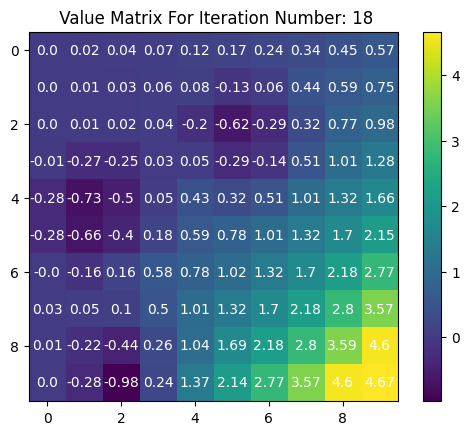

Iteration Number:  19


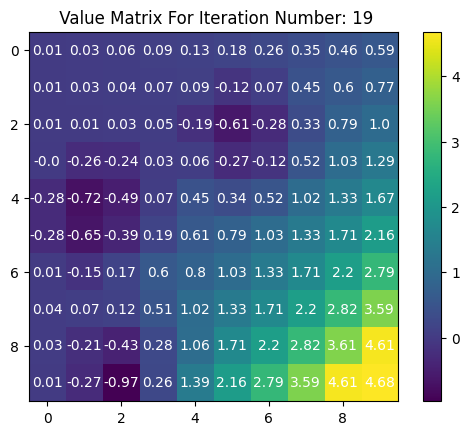

Iteration Number:  20


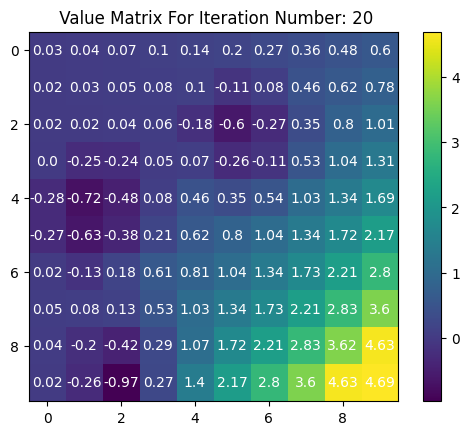

Iteration Number:  21


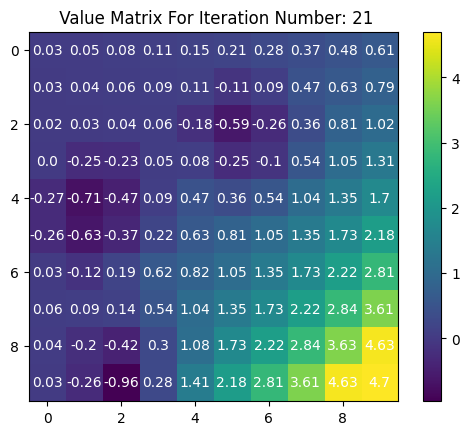

In [10]:
value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 1)

Visualize the result

Total iteration number:  21


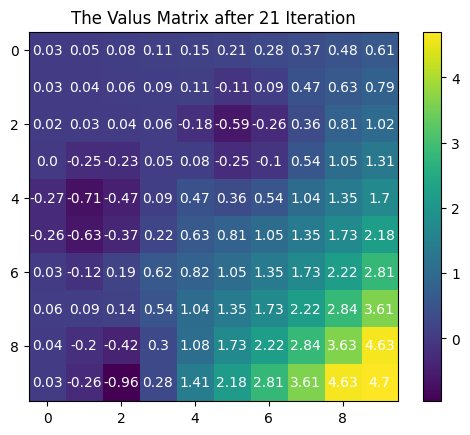

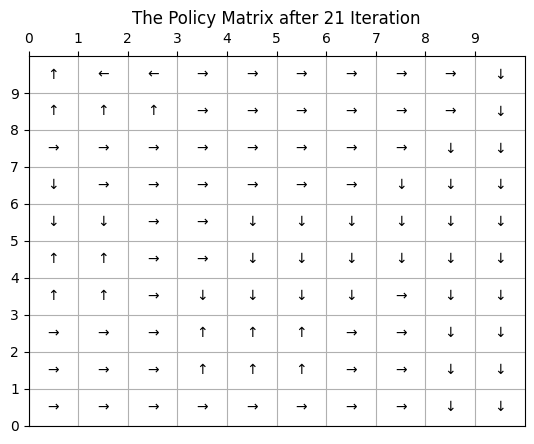

In [11]:
print('Total iteration number: ', str(total_iteration_number))
Imshow_HeatMap(value_matrix.reshape(10,10).T,'The Valus Matrix after '+str(total_iteration_number)+' Iteration')
Imshow_Arrow(policy_matrix.reshape(10,10).T,'The Policy Matrix after '+str(total_iteration_number)+' Iteration')

Q4

shown in our report

Q5

Implement the computation step of the value iteration algorithm (lines 14-17)
to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose,
you should generate a figure similar to that of figure 1 but with the number of state replaced by the
optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal
policy of the agent match your intuition? Please provide a brief explanation. Is it possible for the agent
to compute the optimal action to take at each state by observing the optimal values of it’s neighboring
states? In this question, you should have 1 plot.

Question 6-8

Iteration Number:  1


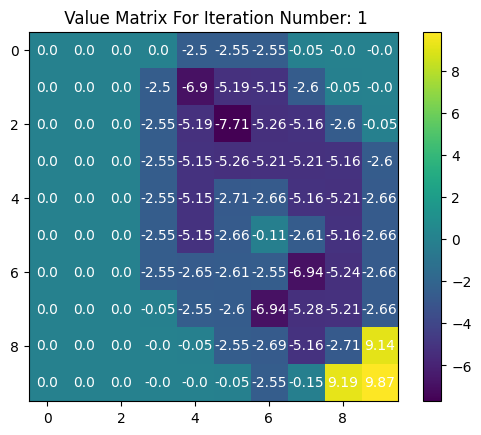

Iteration Number:  2


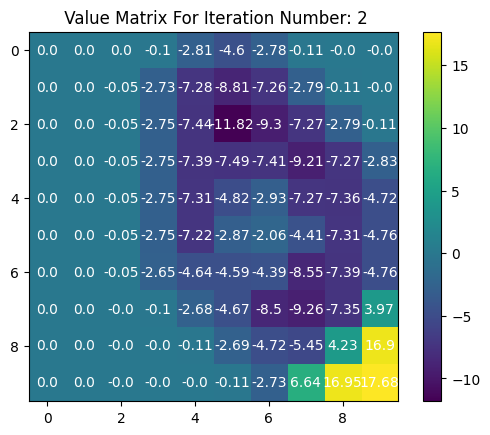

Iteration Number:  3


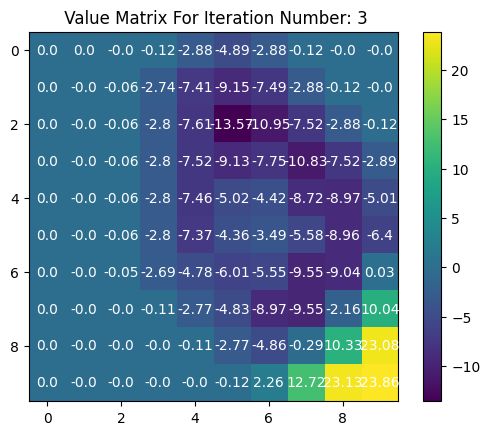

Iteration Number:  4


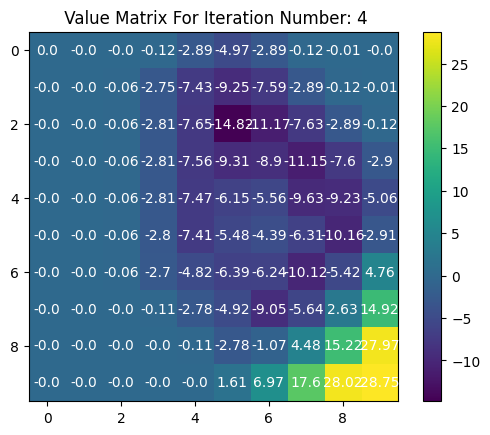

Iteration Number:  5


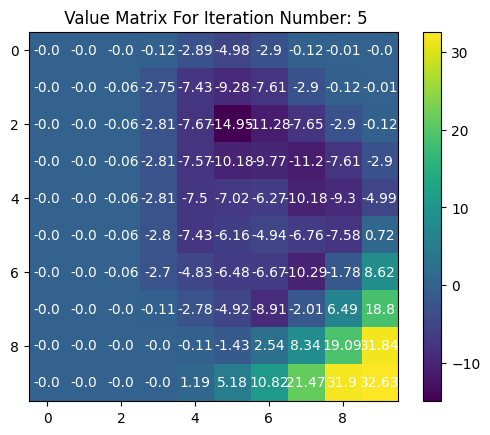

Iteration Number:  6


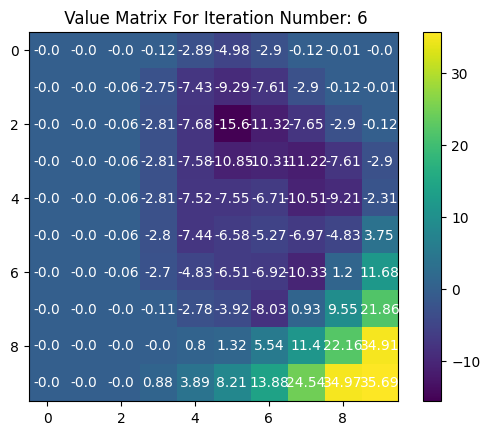

Iteration Number:  7


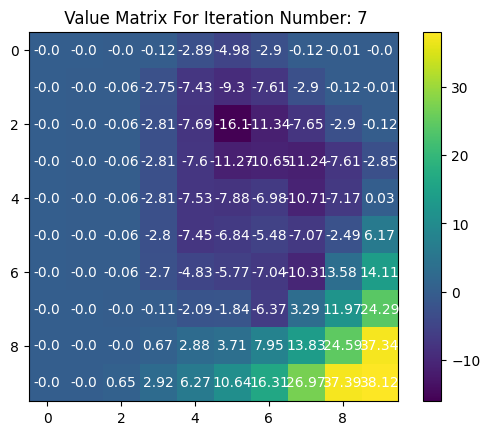

Iteration Number:  8


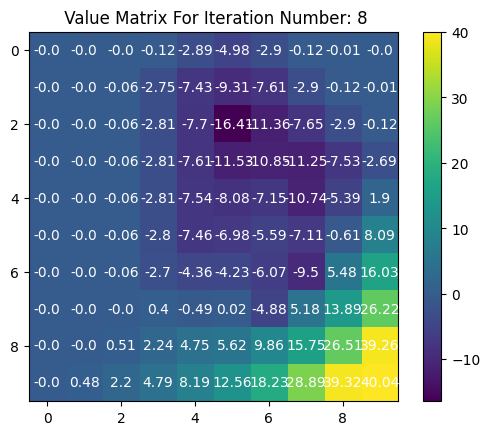

Iteration Number:  9


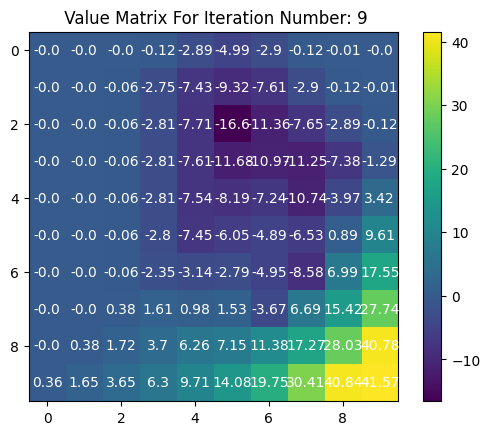

Iteration Number:  10


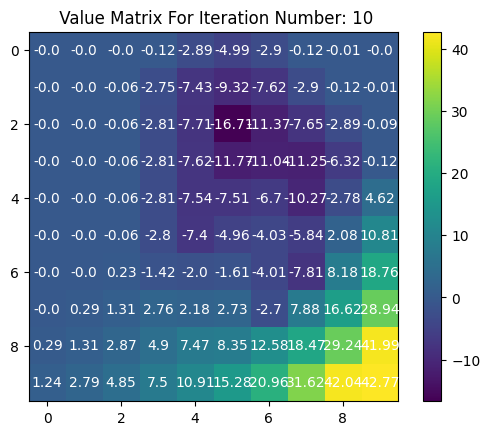

Iteration Number:  11


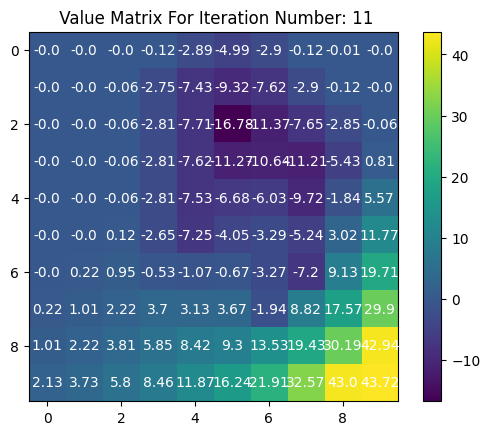

Iteration Number:  12


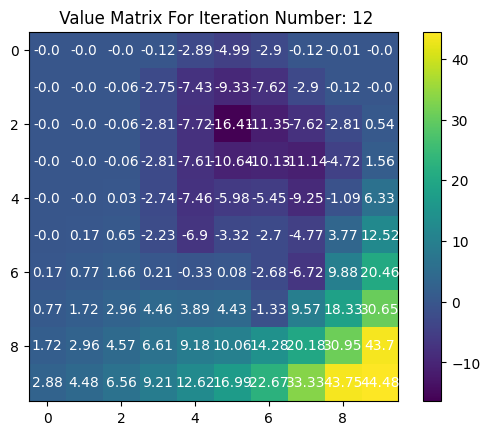

Iteration Number:  13


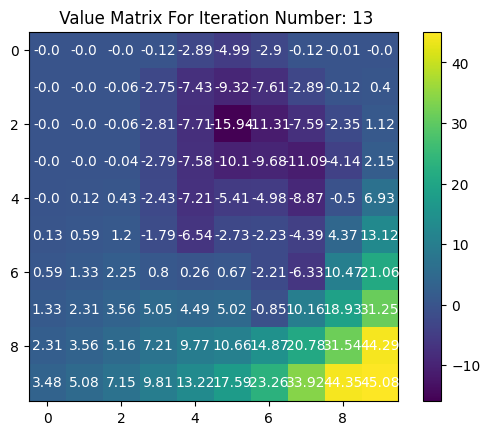

Iteration Number:  14


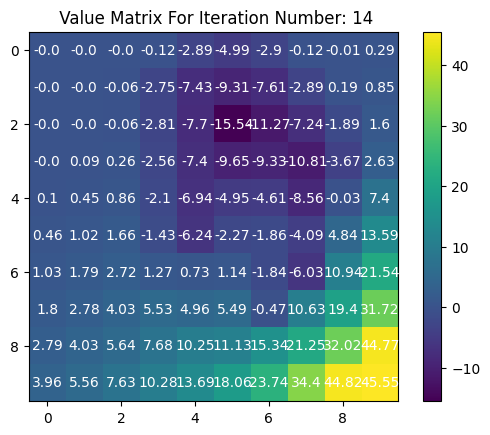

Iteration Number:  15


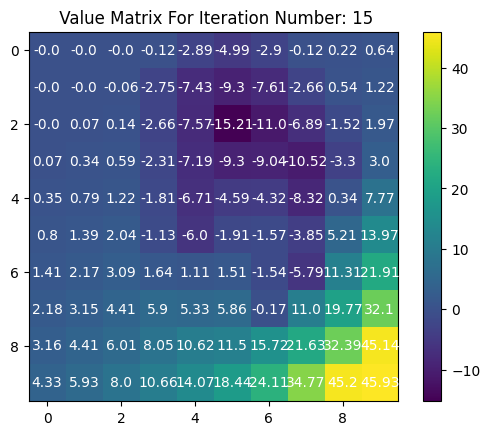

Iteration Number:  16


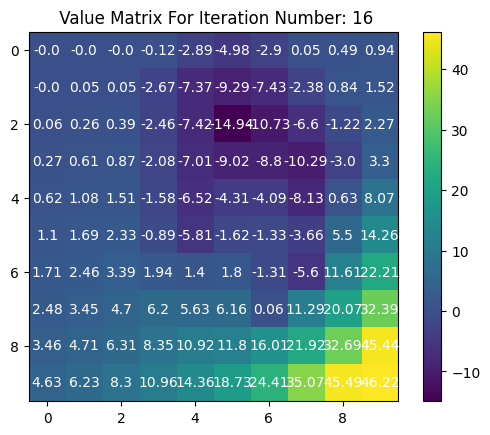

Iteration Number:  17


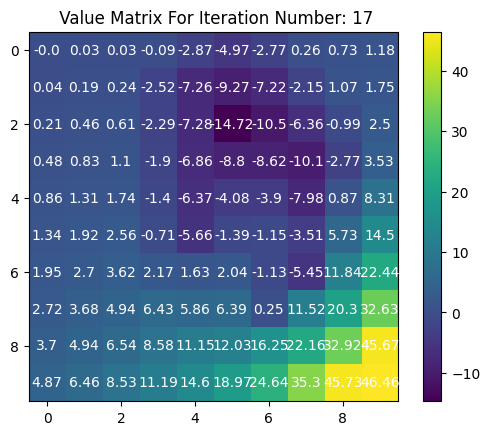

Iteration Number:  18


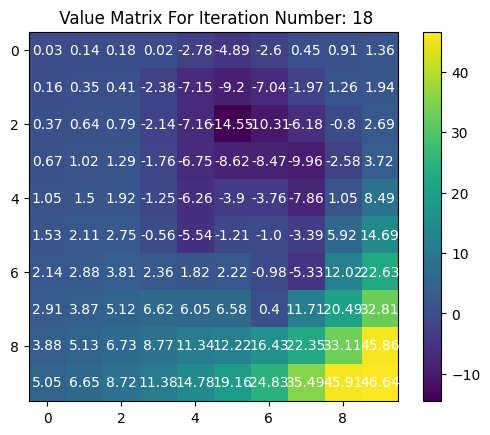

Iteration Number:  19


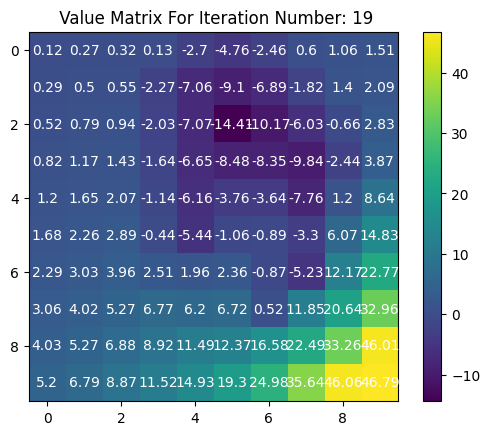

Iteration Number:  20


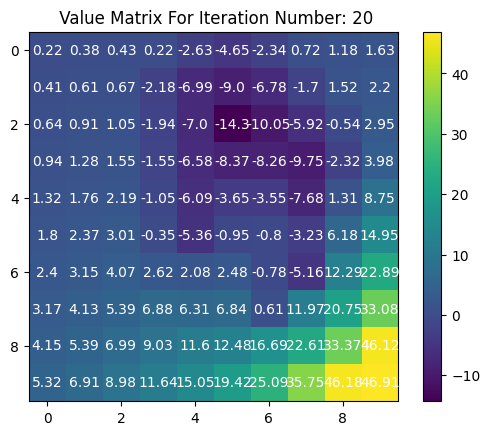

Iteration Number:  21


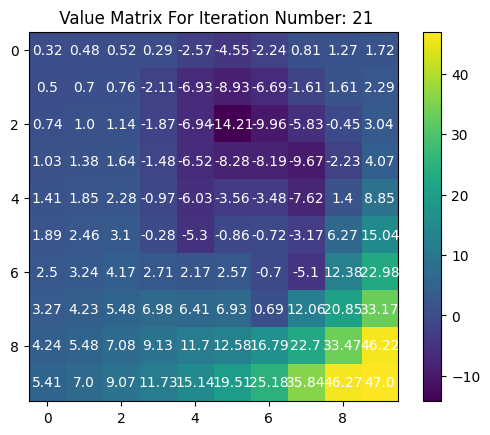

Iteration Number:  22


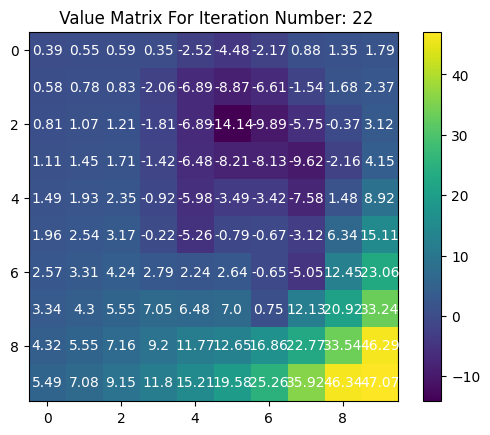

Iteration Number:  23


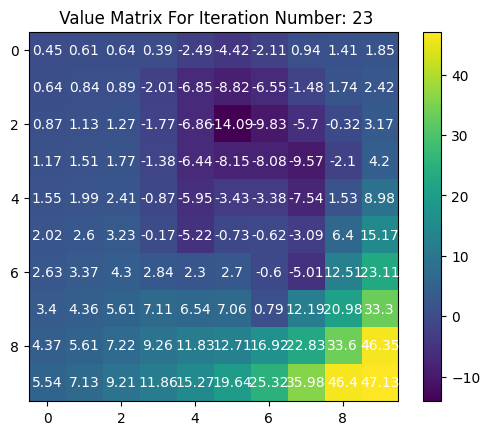

Iteration Number:  24


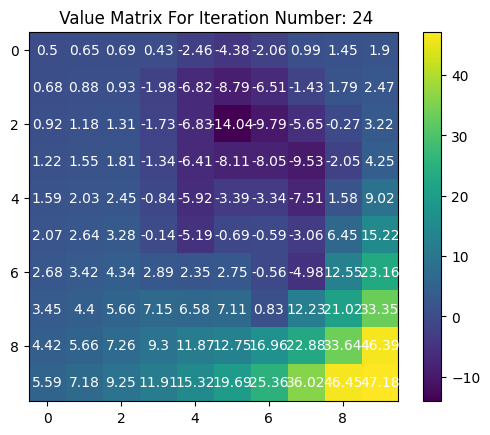

Iteration Number:  25


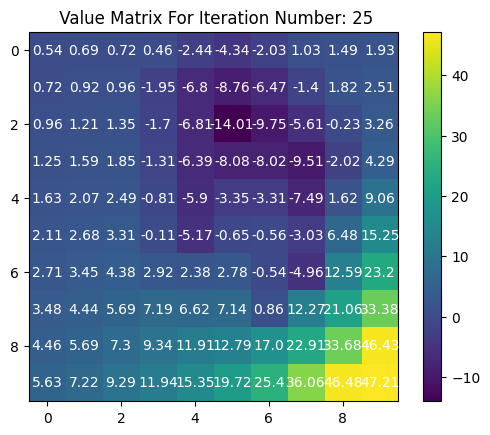

Iteration Number:  26


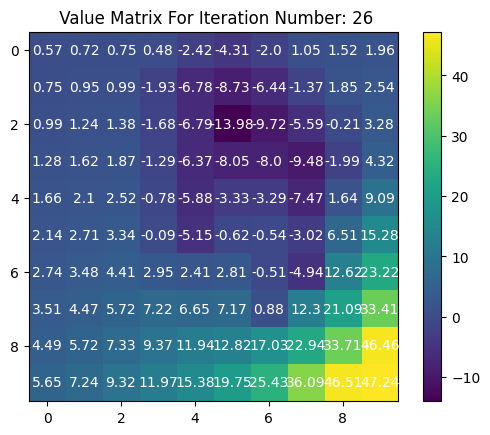

Iteration Number:  27


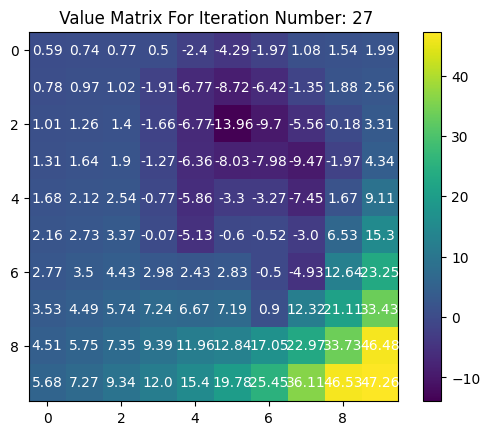

Iteration Number:  28


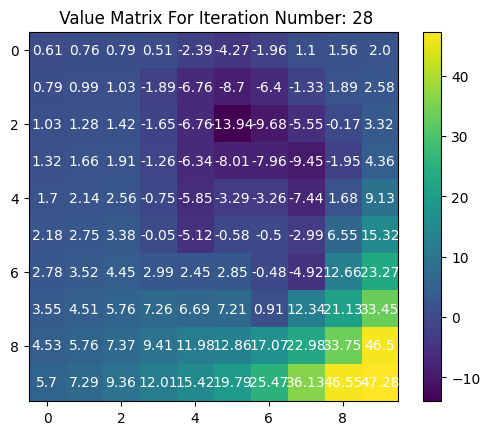

Iteration Number:  29


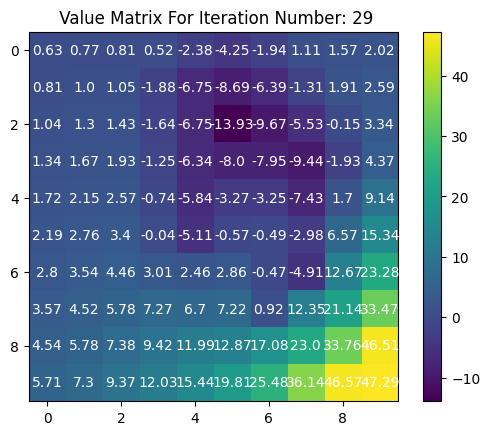

Iteration Number:  30


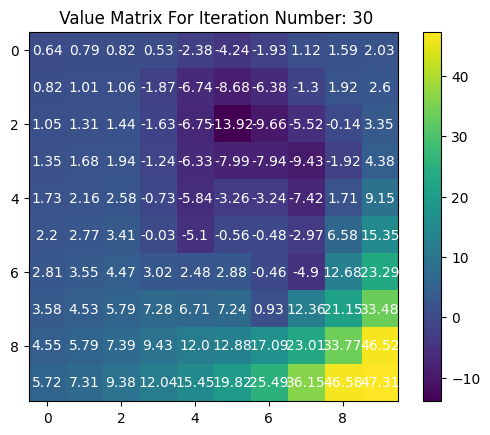

Iteration Number:  31


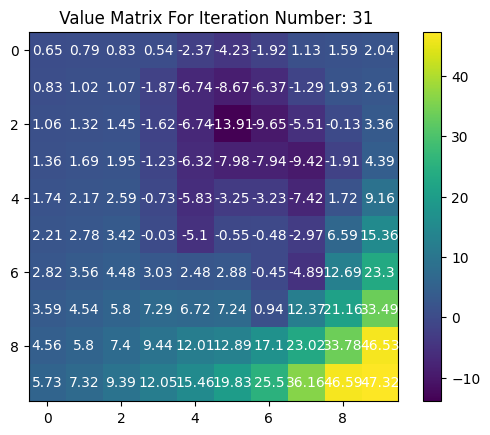

In [12]:
value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_2, 1)

Total iteration number:  31


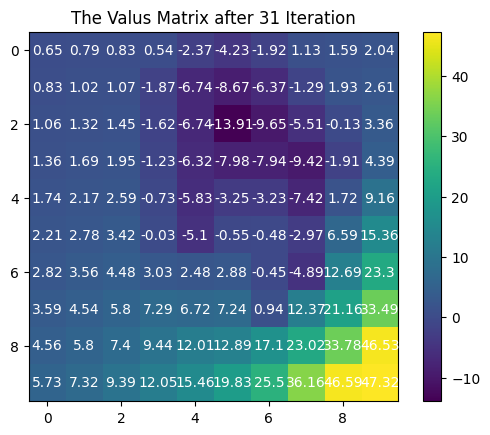

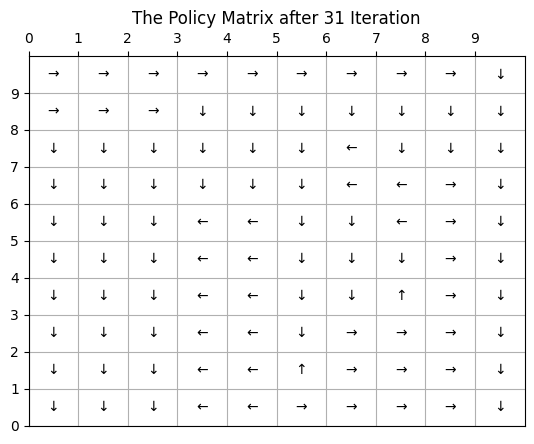

In [14]:
print('Total iteration number: ', str(total_iteration_number))
Imshow_HeatMap(value_matrix.reshape(10,10).T,'The Valus Matrix after '+str(total_iteration_number)+' Iteration')
Imshow_Arrow(policy_matrix.reshape(10,10).T,'The Policy Matrix after '+str(total_iteration_number)+' Iteration')

Question 9

Change the hyper parameter w to 0.6 and find the optimal policy map similar to previous question for reward functions. Explain the differences you observe. What do you think
about value of new w compared to previous value? Choose the w that you think give rise to better
optimal policy and use that w for the next stages of the project.

In [15]:
## Generate the parameters for the Markov Decision Process 
num_of_states = 100
w = 0.6

# Make the Markov Decision Process  
MDP_wind = MDP_gridworld(num_of_states, w)

Using Reward Function 1 with w=0.6

Iteration Number:  1


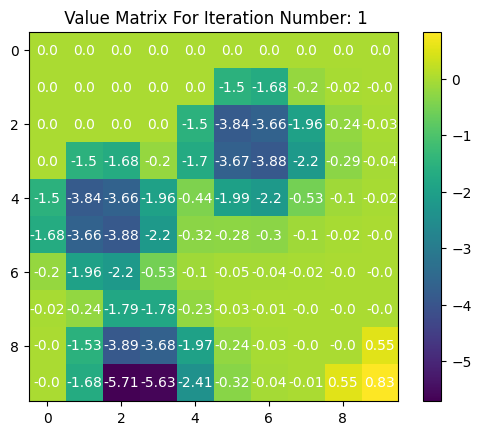

Iteration Number:  2


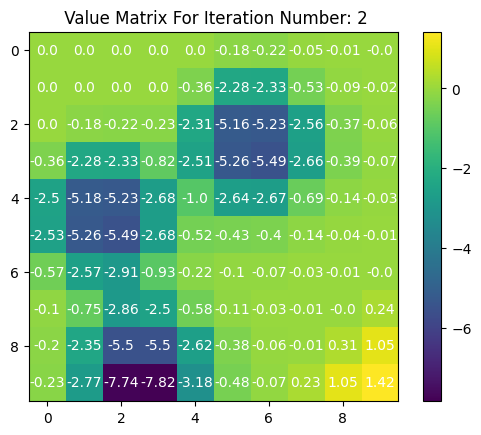

Iteration Number:  3


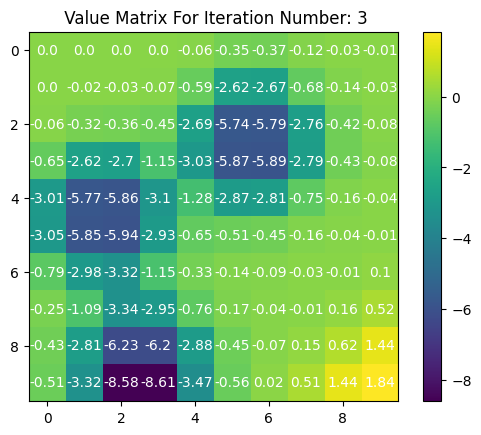

Iteration Number:  4


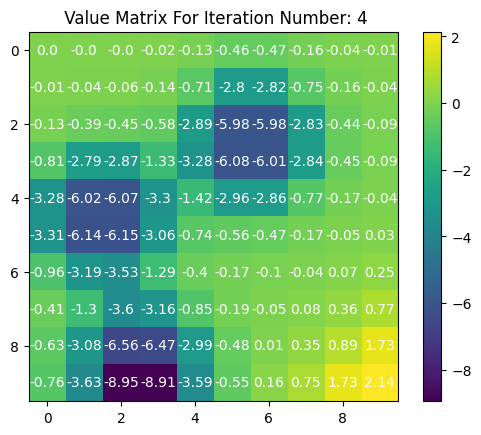

Iteration Number:  5


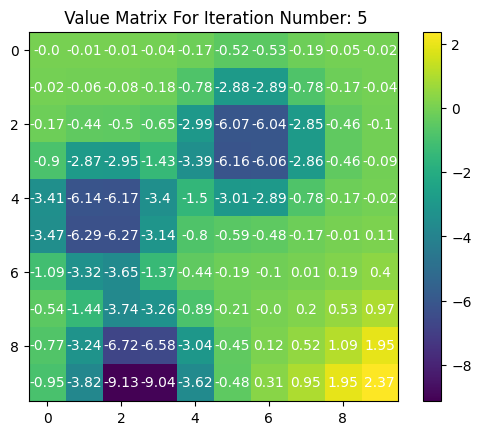

Iteration Number:  6


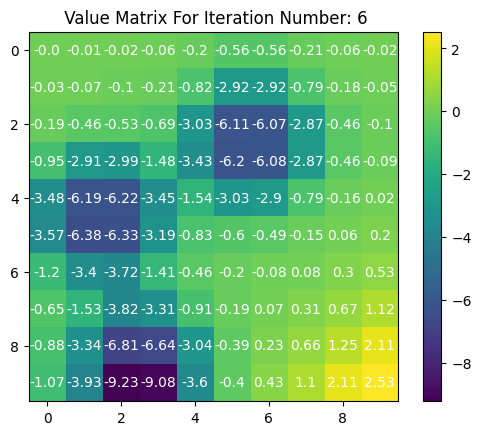

Iteration Number:  7


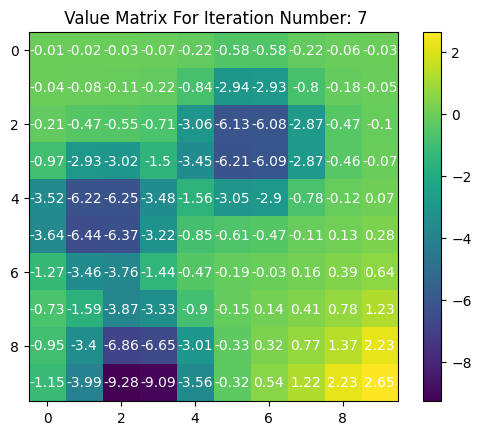

Iteration Number:  8


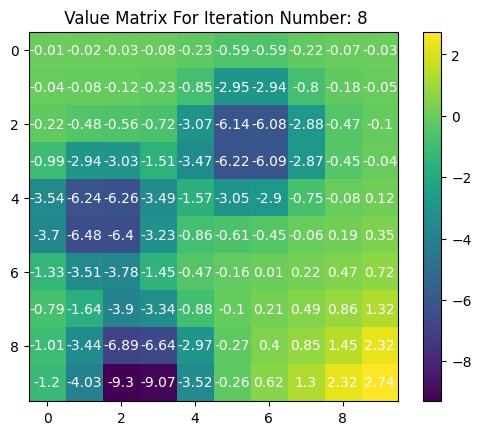

Iteration Number:  9


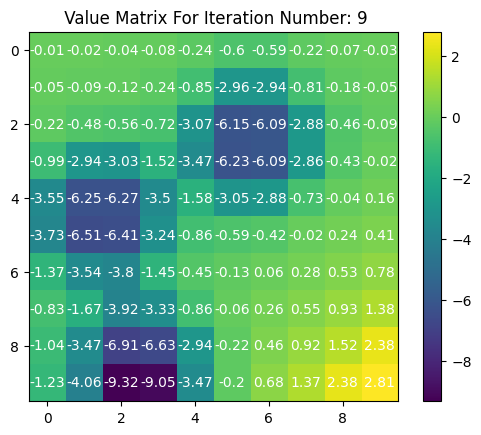

Iteration Number:  10


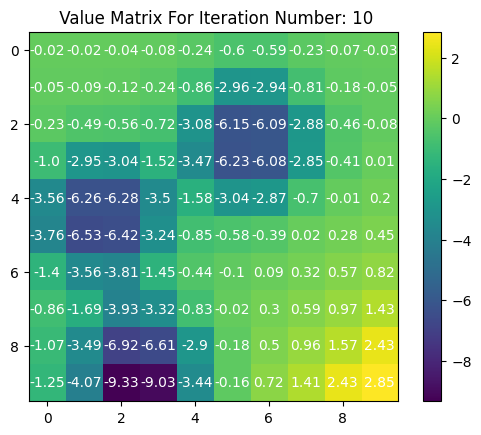

Iteration Number:  11


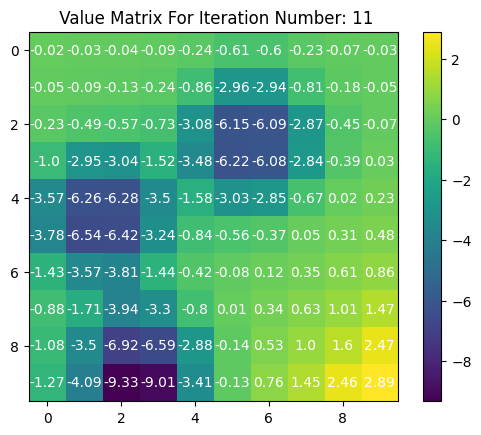

Iteration Number:  12


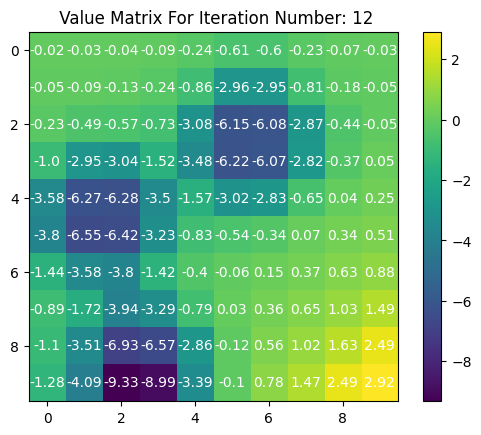

Iteration Number:  13


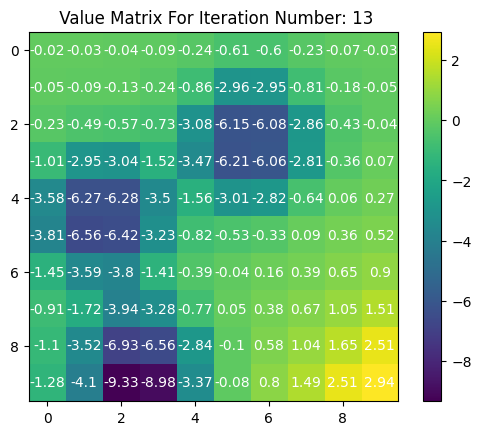

Iteration Number:  14


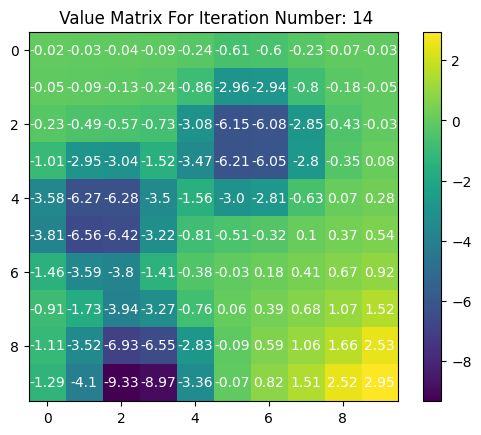

Iteration Number:  15


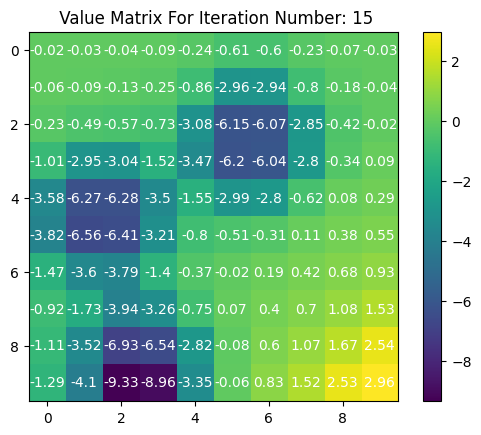

Iteration Number:  16


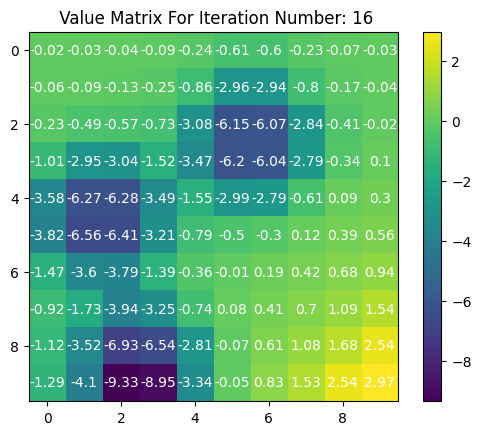

In [16]:
value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_1, 1)

Total iteration number:  16


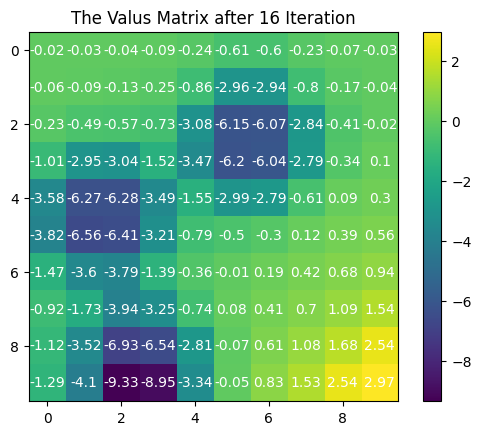

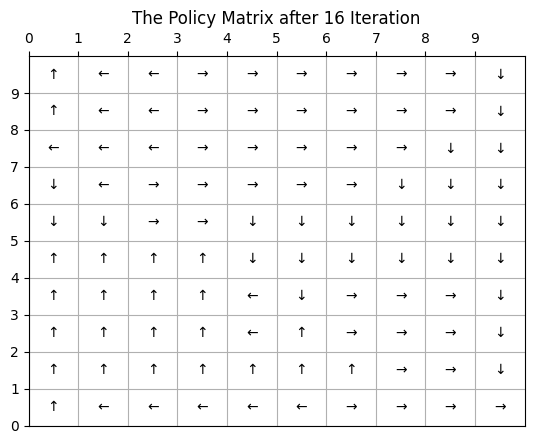

In [17]:
print('Total iteration number: ', str(total_iteration_number))
Imshow_HeatMap(value_matrix.reshape(10,10).T,'The Valus Matrix after '+str(total_iteration_number)+' Iteration')
Imshow_Arrow(policy_matrix.reshape(10,10).T,'The Policy Matrix after '+str(total_iteration_number)+' Iteration')

Using Reward Function 2 with w=0.6

Iteration Number:  1


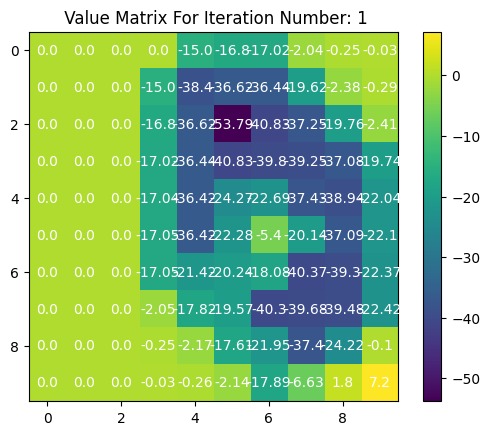

Iteration Number:  2


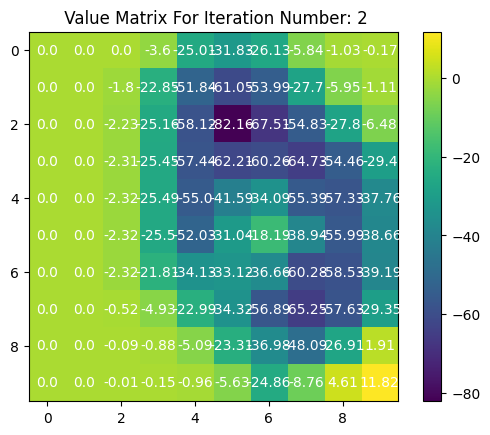

Iteration Number:  3


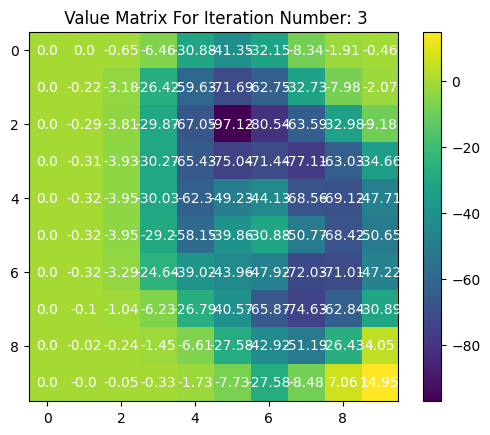

Iteration Number:  4


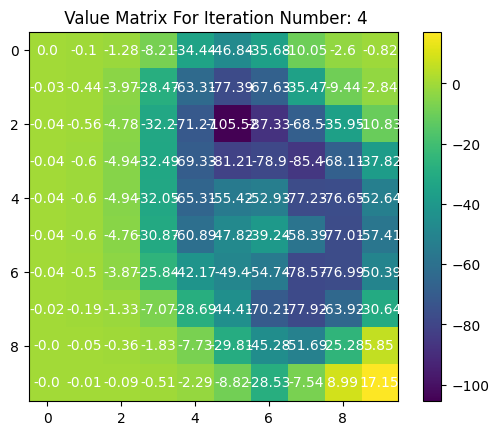

Iteration Number:  5


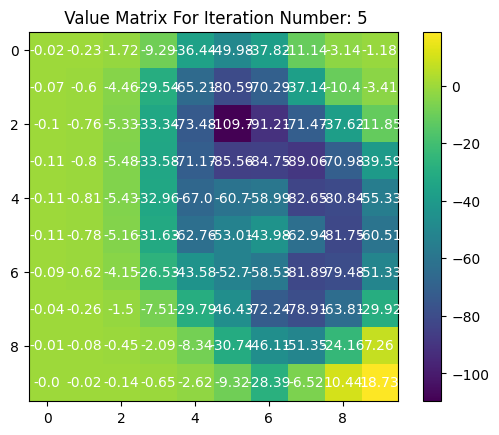

Iteration Number:  6


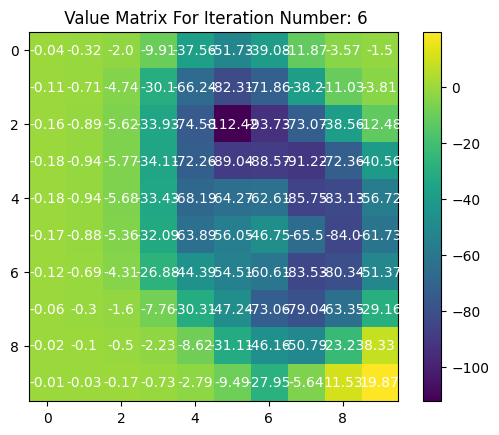

Iteration Number:  7


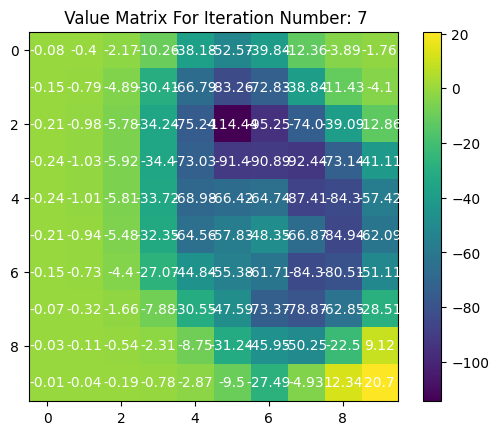

Iteration Number:  8


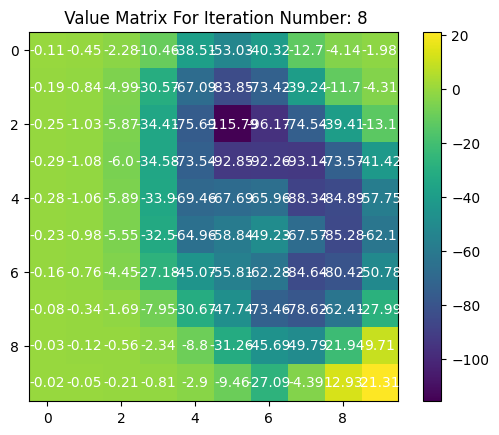

Iteration Number:  9


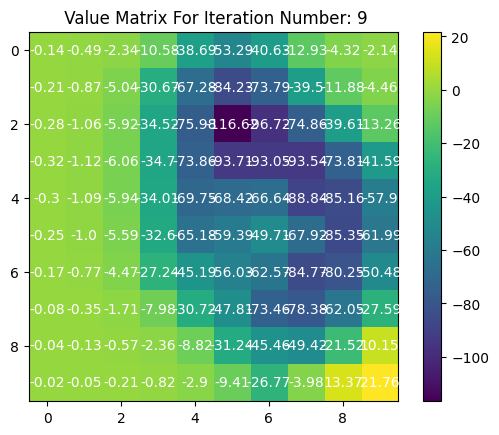

Iteration Number:  10


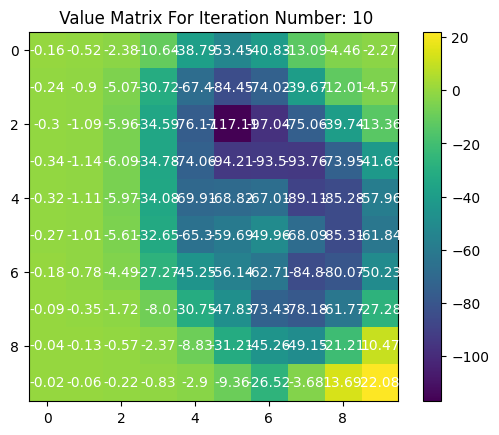

Iteration Number:  11


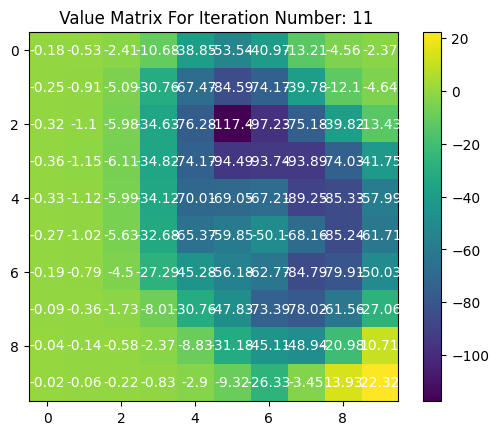

Iteration Number:  12


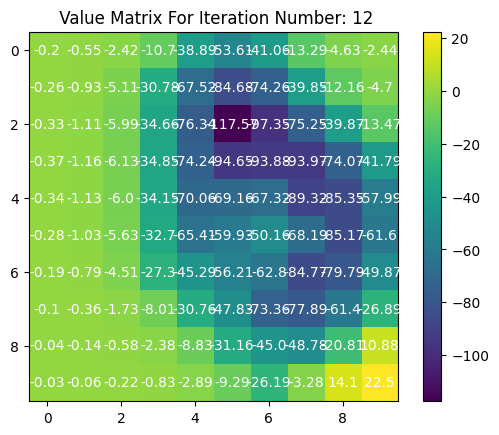

Iteration Number:  13


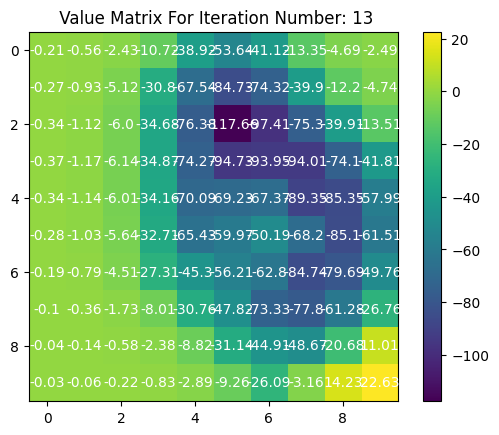

Iteration Number:  14


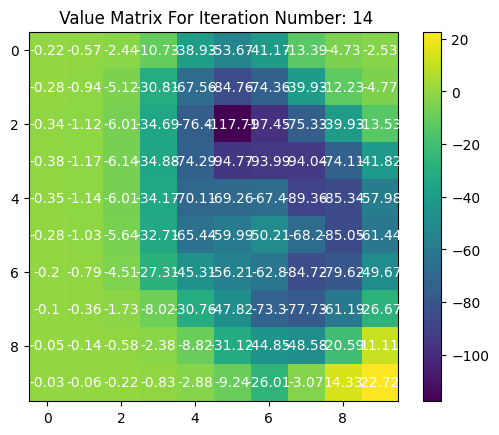

Iteration Number:  15


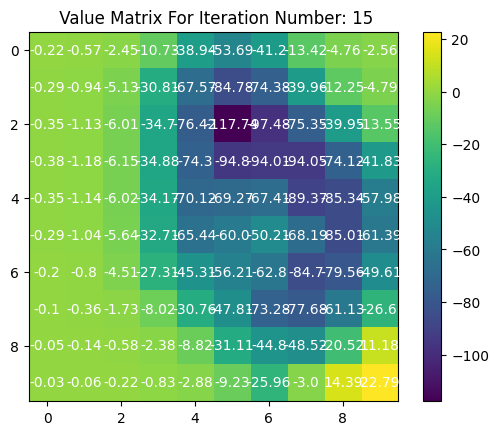

Iteration Number:  16


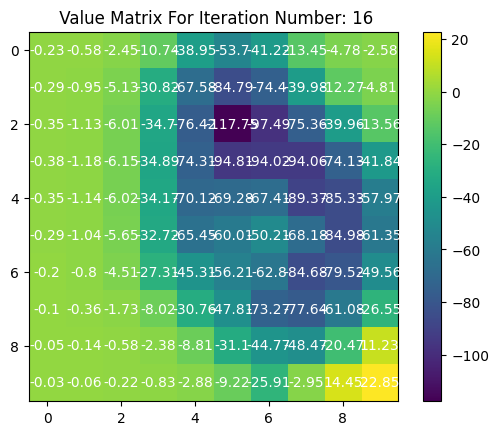

Iteration Number:  17


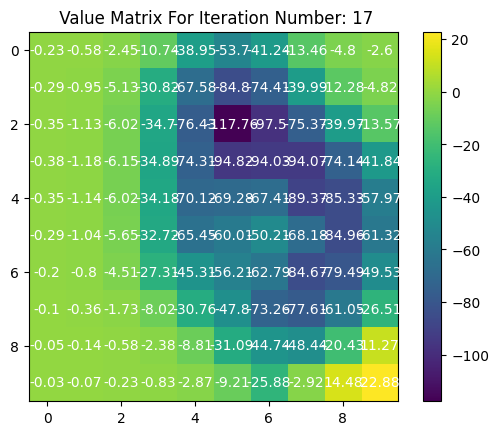

Iteration Number:  18


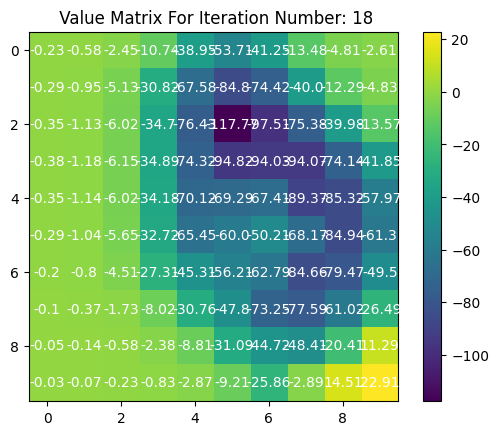

Iteration Number:  19


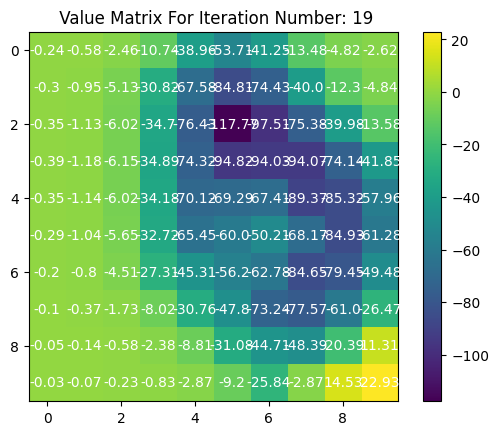

Iteration Number:  20


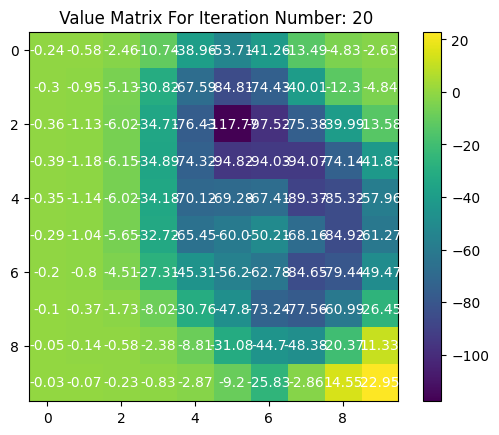

Iteration Number:  21


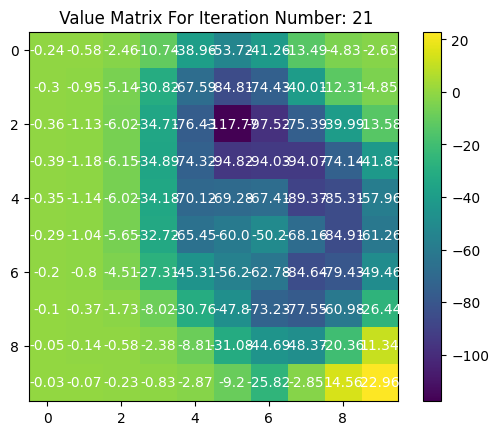

Iteration Number:  22


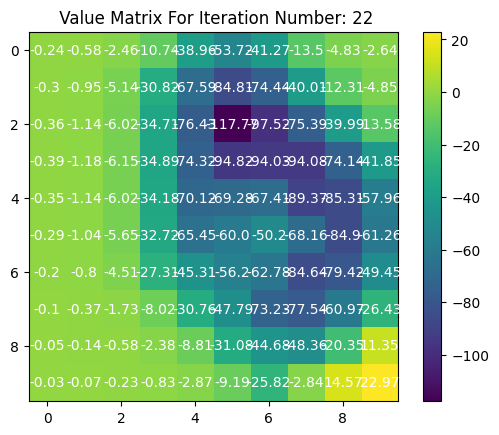

In [18]:
value_matrix, policy_matrix, total_iteration_number = value_iteration_function(MDP_wind, RF_2, 1)

Total iteration number:  22


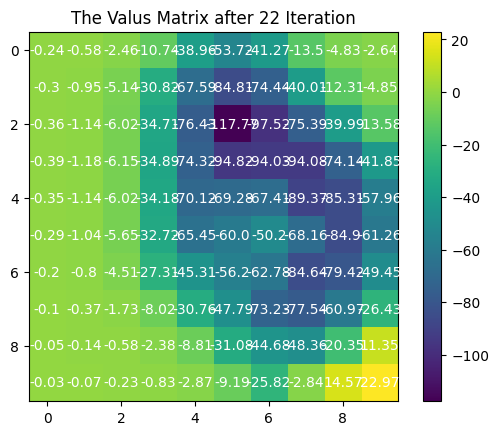

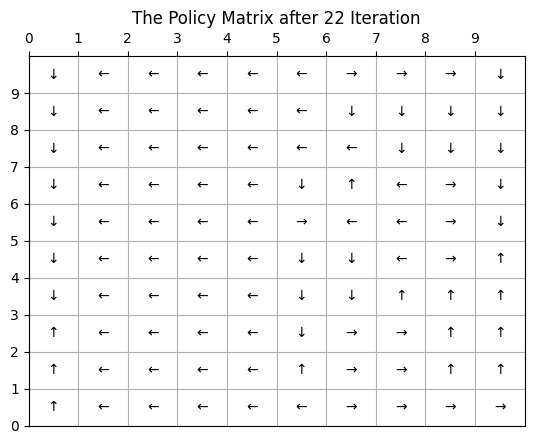

In [19]:
print('Total iteration number: ', str(total_iteration_number))
Imshow_HeatMap(value_matrix.reshape(10,10).T,'The Valus Matrix after '+str(total_iteration_number)+' Iteration')
Imshow_Arrow(policy_matrix.reshape(10,10).T,'The Policy Matrix after '+str(total_iteration_number)+' Iteration')

Question 10

shown in our report
